# Another round of testing ClusterDE

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
import importlib

## Preprocessing
### Read data

In [107]:
data_path = "../../data/filtered_gene_bc_matrices/hg19"
adata = sc.read(data_path + "/pbmc.h5ad")

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


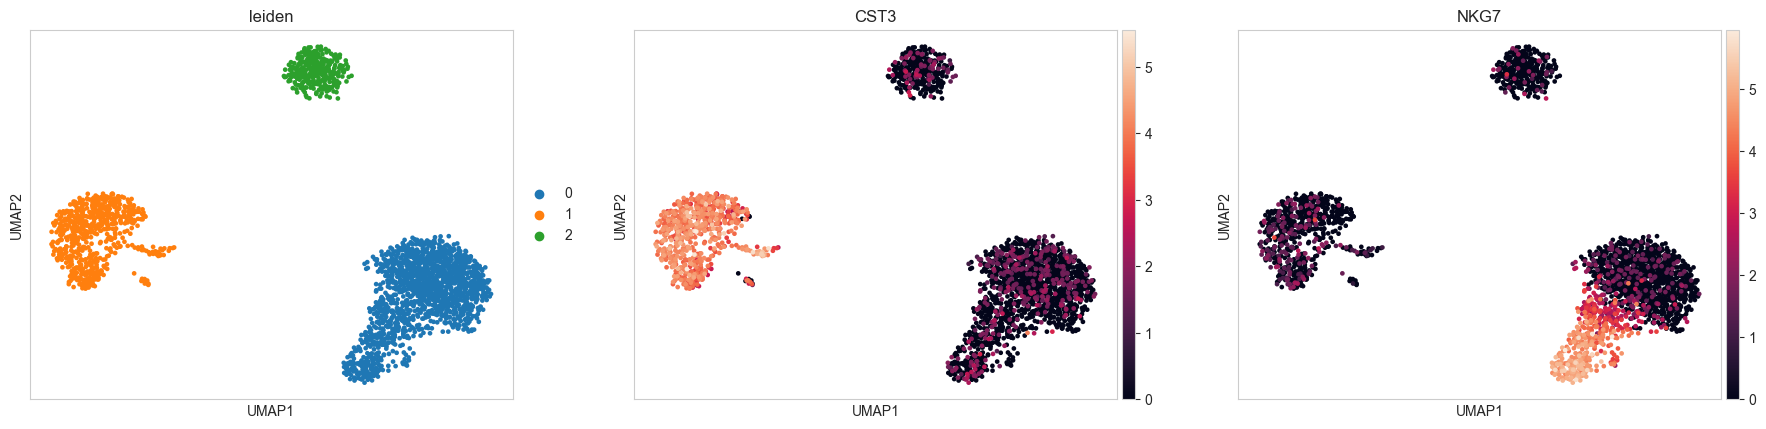

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [109]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

adata

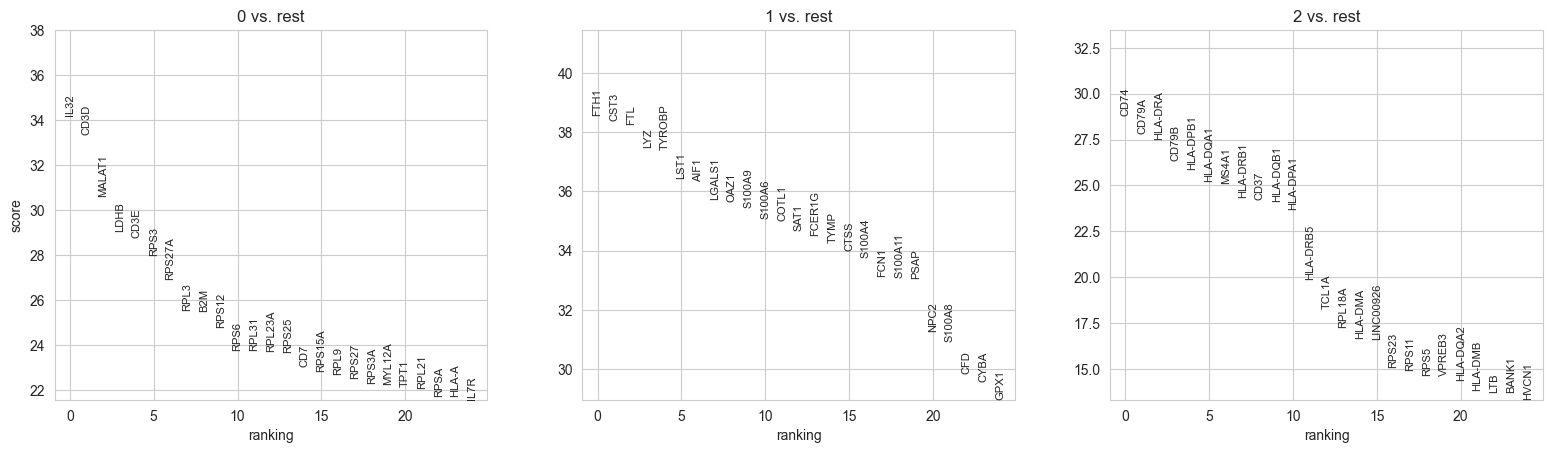

In [110]:
data_gene = adata.copy()
sc.tl.rank_genes_groups(data_gene, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [111]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
gene 100
gene 200
gene 300
gene 400
gene 500
gene 600
gene 700
gene 800
gene 900
gene 1000
gene 1100
gene 1200
gene 1300
gene 1400
gene 1500
gene 1600
gene 1700
gene 1800


In [112]:
data_gene.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
TNFRSF4,155,False,155,0.077407,94.259259,209.0,True,0.277410,2.086050,0.665406,0.103222,0.425928,0.078848,0.165125,-0.086277,nb,0.078848,0.114325,0.000000
CPSF3L,202,False,202,0.094815,92.518519,256.0,True,0.385194,4.506988,2.955005,0.126284,0.460699,0.095527,0.689131,-0.593604,nb,0.095527,0.174155,0.000000
ATAD3C,9,False,9,0.009259,99.666667,25.0,True,0.038252,3.953487,4.352608,0.005938,0.119467,0.009098,0.112123,-0.103026,nb,0.009098,0.000803,0.000000
C1orf86,501,False,501,0.227778,81.444444,615.0,True,0.678283,2.713522,0.543183,0.318882,0.687385,0.228961,0.722406,-0.493445,nb,0.228961,0.724605,0.000012
RER1,608,False,608,0.298148,77.481481,805.0,True,0.814813,3.447533,1.582528,0.386946,0.742086,0.298711,1.591590,-1.292879,nb,0.298711,0.155217,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICOSLG,34,False,34,0.016667,98.740741,45.0,True,0.082016,2.585818,1.652185,0.024066,0.217785,0.017058,0.052400,-0.035342,nb,0.017230,0.024532,0.009744
SUMO3,570,False,570,0.292963,78.888889,791.0,True,0.804815,4.046776,2.431045,0.364344,0.729211,0.291130,1.854592,-1.563462,nb,0.291130,0.082491,0.000000
SLC19A1,31,False,31,0.018519,98.851852,50.0,True,0.058960,3.234231,2.932458,0.017154,0.173428,0.018196,0.161913,-0.143717,nb,0.018196,0.002303,0.000000
S100B,94,False,94,0.076667,96.518519,207.0,True,0.286282,3.042992,1.078783,0.072484,0.400263,0.077331,0.315476,-0.238144,nb,0.077331,0.025743,0.000000


In [113]:
importlib.reload(cd)
data_null_gen = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True)
data_null_gen

AnnData object with n_obs × n_vars = 2638 × 1838

In [114]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

data_gene.var["var_counts"] = np.asarray(np.var(data_gene.layers["counts"].toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.layers["counts"].toarray(), axis=0)).squeeze()

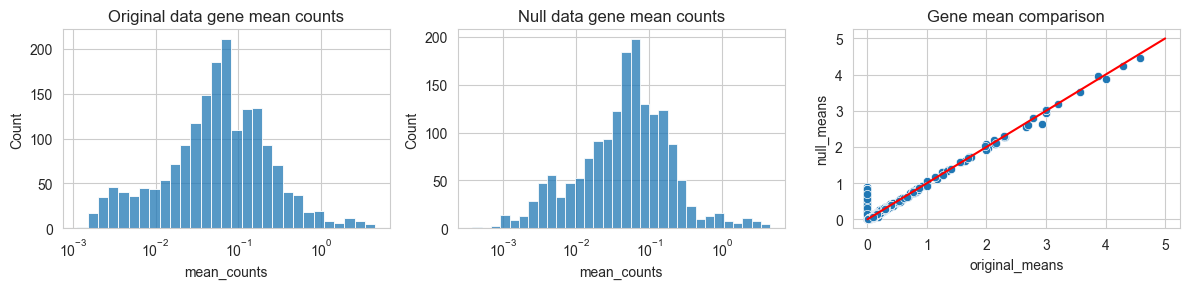

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_null_gen.var["mean_counts"], "null_means": data_gene.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

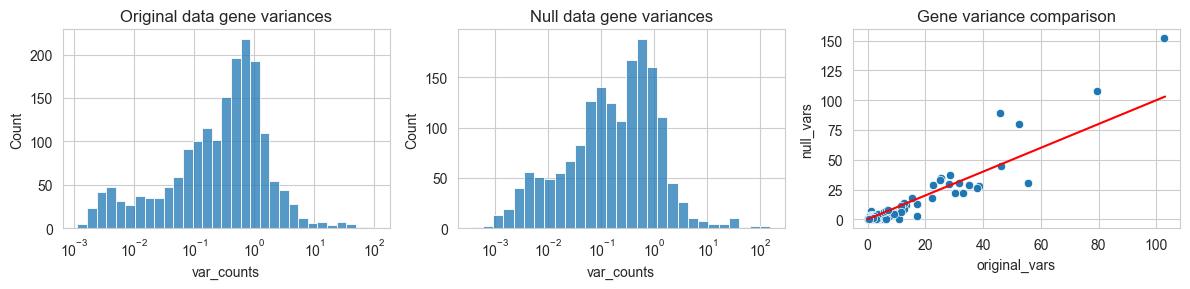

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
var_df["diff"] = var_df["null_vars"] - var_df["original_vars"]

sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

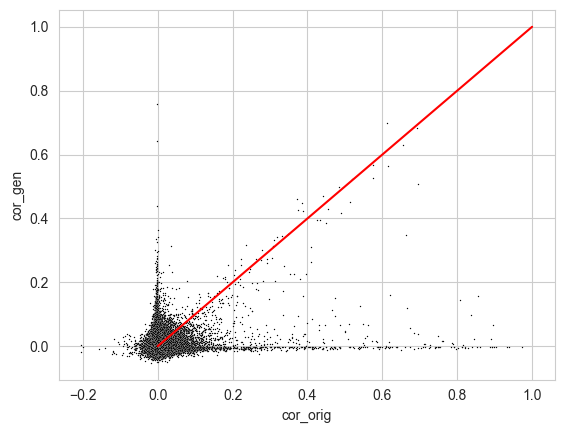

In [117]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = np.corrcoef(data_null_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### process newly generated data

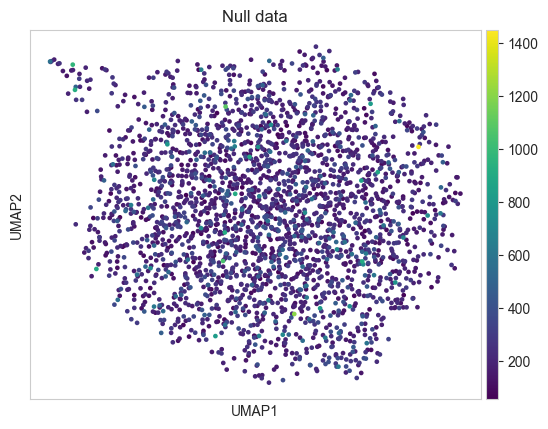

In [118]:
sc.pp.calculate_qc_metrics(data_null_gen, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=1e4)
sc.pp.log1p(data_null_gen)
sc.pp.highly_variable_genes(data_null_gen, min_mean=0.0125, max_mean=3, min_disp=0.5)
data_null_gen.raw = data_null_gen
data_null_gen = data_null_gen[:, data_null_gen.var.highly_variable]
sc.pp.scale(data_null_gen, max_value=10)
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=10, n_pcs=40)
sc.tl.umap(data_null_gen)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")

In [119]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

Resolution for two clusters: 0.12999999999999998


In [120]:
importlib.reload(cd)
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden"].unique()

DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}")

Cluster 0 - DE genes: 121
Cluster 2 - DE genes: 145
Cluster 1 - DE genes: 227


In [121]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}")

Cluster 0 - DE genes: 0
Cluster 2 - DE genes: 0
Cluster 1 - DE genes: 0


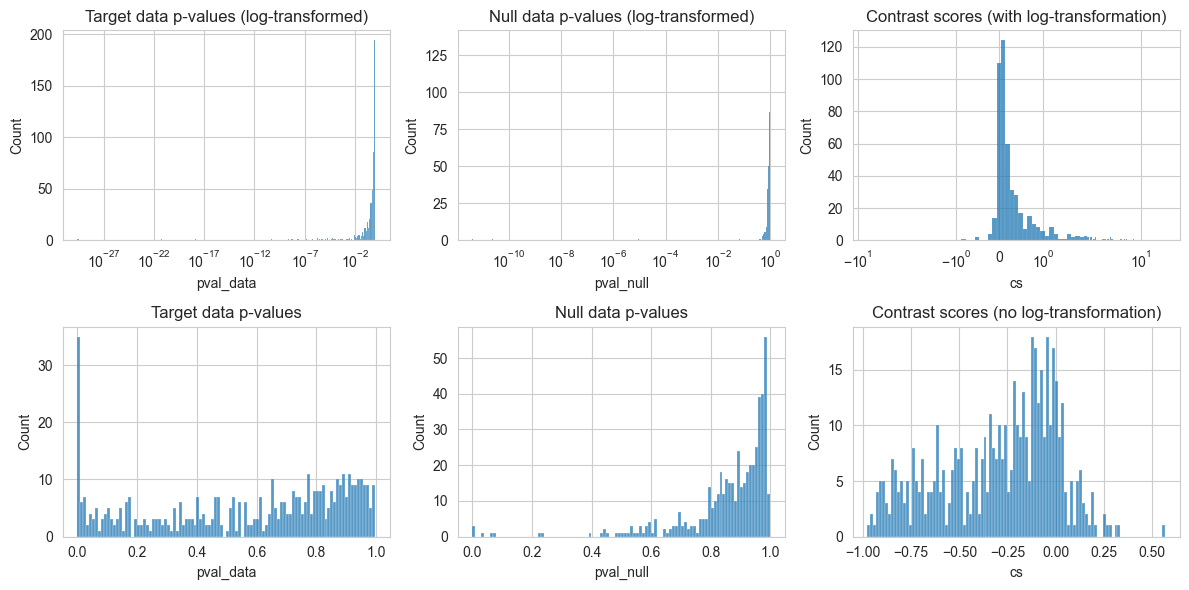

In [123]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

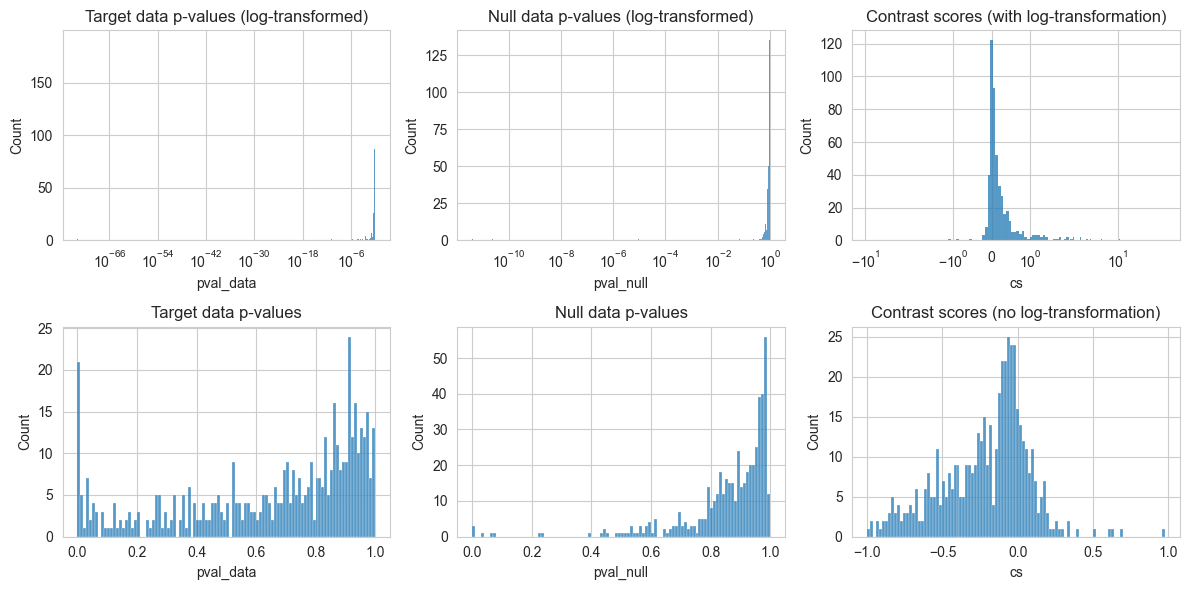

In [124]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [125]:
pvals_gen["2"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PF4,0.975900,2.417303e-11,0.975900,2.417303e-11,0.975900,1.0
GNG11,0.695819,9.237032e-06,0.695819,9.237032e-06,0.695810,1.0
PPBP,0.631936,4.055932e-12,0.631936,4.055932e-12,0.631936,1.0
GP9,0.835890,2.202435e-01,0.835890,2.202435e-01,0.615647,1.0
CLU,0.575265,7.102821e-02,0.575265,7.102821e-02,0.504237,1.0
...,...,...,...,...,...,...
IGJ,0.000242,9.247072e-01,0.000242,9.247072e-01,-0.924465,1.0
ARHGAP24,0.000001,9.320127e-01,0.000001,9.320127e-01,-0.932012,1.0
BACE2,0.012616,9.773131e-01,0.012616,9.773131e-01,-0.964697,1.0
TNFSF10,0.000396,9.778020e-01,0.000396,9.778020e-01,-0.977406,1.0
